#  Lab: The beta-binomial model of globe-tossing

##### Keywords: bayesian, conjugate prior, beta, binomial, beta-binomial, bayesian updating, loss function, decision theory, sampling as marginalization, plug-in approximation

Reading: McElreath Ch 3: Sampling the Imaginary

In [1]:
%matplotlib inline
import numpy as np
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

## Formulation of the problem

This problem, taken from McElreath's book, involves a seal (or a well trained human) tossing a globe, catching it  on the nose, and noting down if the globe came down on  water or land.

The seal tells us that the first 9 samples were:

`WLWWWLWLW`.

We wish to understand the evolution of belief in the fraction of water on earth as the seal tosses the globe.

Suppose $\theta$ is the true fraction of  water covering the globe. Our data story if that $\theta$ then is the probability of the nose landing on water, with each throw or toss of the globe being independent.

Now we build a  probabilistic model for the problem, which we shall use to guide a process of **Bayesian updating** of the model as data comes in.

$$\cal{L} = p(n,k|\theta) = Binom(n,k, \theta)=\frac{n!}{k! (n-k)! } \, \theta^k \, (1-\theta)^{(n-k)} $$

Since our seal hasnt really seen any water or land, (strange, I know), it assigns equal probabilities, ie uniform probability to any value of $\theta$.

**This is our prior information**

For reasons of conjugacy we 
choose as prior the beta distribution, with $Beta(1,1)$ being the uniform prior.

## How to do the Bayesian Process

Bayes theorem and the things we will go through

(1) Grid approximation
(2) Quadratic (Laplace) Approximation
(3) Conjugate Priors
(4) MCMC (later)
(5) Model Checking

In [2]:
from scipy.stats import binom

In [3]:
prior_pdf = lambda p: 1
like_pdf = lambda p: binom.pmf(k=6, n=9, p=p)
post_pdf = lambda p: like_pdf(p)*prior_pdf(p)

## Grid Approximation

Create posterior grid, normalize, and use ys as probability weights for sampling (horizontally along the grid).

In [4]:
p_grid = np.linspace(0., 1., 20)
p_grid

array([ 0.        ,  0.05263158,  0.10526316,  0.15789474,  0.21052632,
        0.26315789,  0.31578947,  0.36842105,  0.42105263,  0.47368421,
        0.52631579,  0.57894737,  0.63157895,  0.68421053,  0.73684211,
        0.78947368,  0.84210526,  0.89473684,  0.94736842,  1.        ])

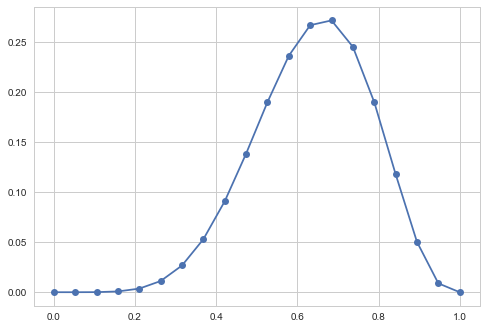

In [5]:
plt.plot(p_grid, post_pdf(p_grid),'o-');

In [7]:
p_grid = np.linspace(0., 1., 1000)
post_vals = post_pdf(p_grid)
# renormalize, convert to probabilities
post_vals_normed = post_vals/np.sum(post_vals)
# sample from grid according to normalized
grid_post_samples = np.random.choice(p_grid, size=10000, replace=True, p=post_vals_normed)

Works for 1D, but awful in high dimensionality.

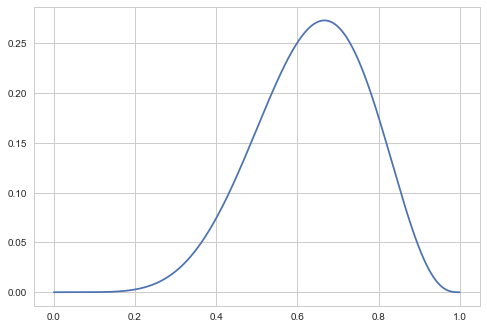

In [10]:
plt.plot(p_grid, post_vals);

C:\Users\Jackie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


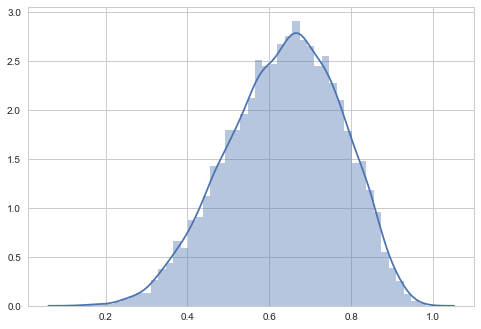

In [11]:
sns.distplot(grid_post_samples);

## Laplace Approximation

Near the mean, all distributions are approximately Gaussian. Prove by Taylor expanding the logarithm of the pdf around the peak.

Fit Gaussian to posterior function, then sample from the Gaussian.

In [12]:
p_start = 0.5
from scipy.optimize import minimize
post_pdf_inv = lambda p: -post_pdf(p)
res = minimize(post_pdf_inv, p_start, method = 'Nelder-Mead', options={'disp': True})

Optimization terminated successfully.
         Current function value: -0.273129
         Iterations: 13
         Function evaluations: 26


In [13]:
res

 final_simplex: (array([[ 0.66669922],
       [ 0.66660156]]), array([-0.27312909, -0.27312907]))
           fun: -0.27312909031345828
       message: 'Optimization terminated successfully.'
          nfev: 26
           nit: 13
        status: 0
       success: True
             x: array([ 0.66669922])

In [14]:
post_MAP = res.x[0]
post_MAP

0.66669921875000038

In [15]:
# find index where post_MAP would be inserted
insertbefore = np.searchsorted(p_grid, post_MAP)
insertbefore

667

In [16]:
# trying to get rough idea of unnormalized value of posterior at max
postmapval = (post_vals[insertbefore-1] + post_vals[insertbefore])/2.
postmapval

0.27312632244812729

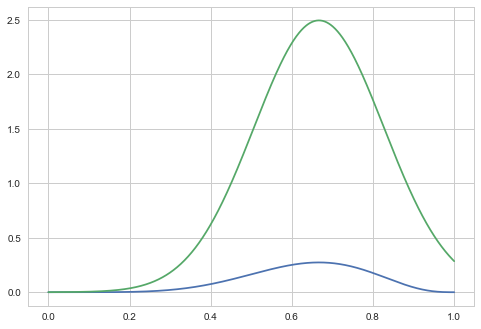

In [17]:
# play with scaling to get these 2 curves to match
plt.plot(p_grid, post_vals);
plt.plot(p_grid, norm.pdf(p_grid, loc=post_MAP, scale=0.16));

In [18]:
zq = lambda sigma: sigma*postmapval*np.sqrt(2*np.pi)
# take dif between normalized posterior value and pdf 
def fit_loss(sigma):
    vec = (post_vals/zq(sigma)) - norm.pdf(p_grid, loc=post_MAP, scale=sigma)
    return np.dot(vec, vec)

In [19]:
res2 = minimize(fit_loss, 0.2, method = 'Nelder-Mead', options={'disp': True})

Optimization terminated successfully.
         Current function value: 23.987144
         Iterations: 12
         Function evaluations: 24


In [20]:
res2

 final_simplex: (array([[ 0.14921875],
       [ 0.14917969]]), array([ 23.9871437 ,  23.98715773]))
           fun: 23.987143699357638
       message: 'Optimization terminated successfully.'
          nfev: 24
           nit: 12
        status: 0
       success: True
             x: array([ 0.14921875])

In [21]:
post_SIG = res2.x[0]
post_SIG

0.14921875000000009

In [22]:
frozen_laplace = norm(post_MAP, post_SIG)

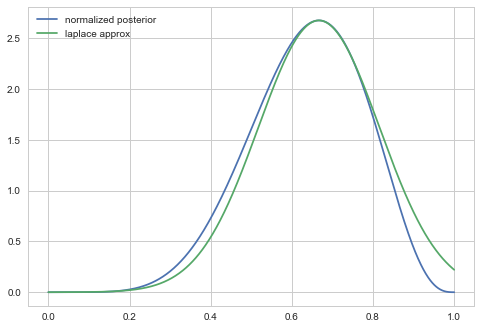

In [23]:
plt.plot(p_grid, post_pdf(p_grid)/zq(post_SIG), label = "normalized posterior");
plt.plot(p_grid, frozen_laplace.pdf(p_grid), label = "laplace approx")
plt.legend();

In [24]:
zq(post_SIG)

0.10215906016979832

Now we can get samples from here:

C:\Users\Jackie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


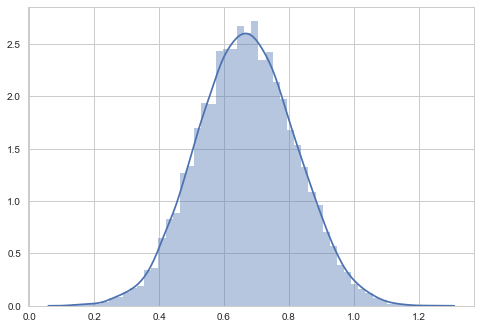

In [25]:
sns.distplot(frozen_laplace.rvs(10000));

## Conjugate Priors

The  mean of $Beta(\alpha, \beta)$ is  $\mu = \frac{\alpha}{\alpha+\beta}$ while the variance is 

$$V=\mu (1- \mu)/(\alpha + \beta + 1)$$

Assume conjugate prior distribution. 

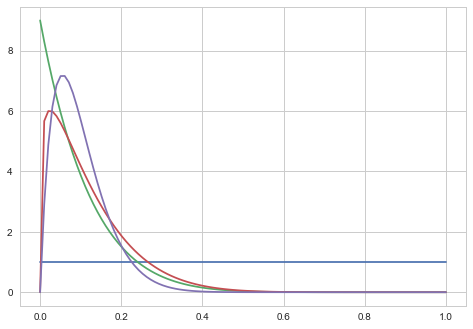

In [26]:
from scipy.stats import beta
x=np.linspace(0., 1., 100)
plt.plot(x, beta.pdf(x, 1, 1));
plt.plot(x, beta.pdf(x, 1, 9));
plt.plot(x, beta.pdf(x, 1.2, 9));
plt.plot(x, beta.pdf(x, 2, 18));

We shall choose $\alpha=1$ and $\beta=1$ to be uniform.

$$ p(\theta) = {\rm Beta}(\theta,\alpha, \beta) = \frac{\theta^{\alpha-1} (1-x)^{\beta-1} }{B(\alpha, \beta)} $$
where $B(\alpha, \beta)$ is independent of $\theta$ and it is the normalization factor.

From Bayes theorem, the posterior for $\theta$ is 

$$ p(\theta|D) \propto  p(\theta) \, p(n,k|\theta)  =  Binom(n,k, \theta) \,  {\rm Beta}(\theta,\alpha, \beta)  $$

which can be shown to be 

$${\rm Beta}(\theta, \alpha+k, \beta+n-k)$$

Beta is nice because it provides interpretability.

[1 0 1 1 1 0 1 0 1]


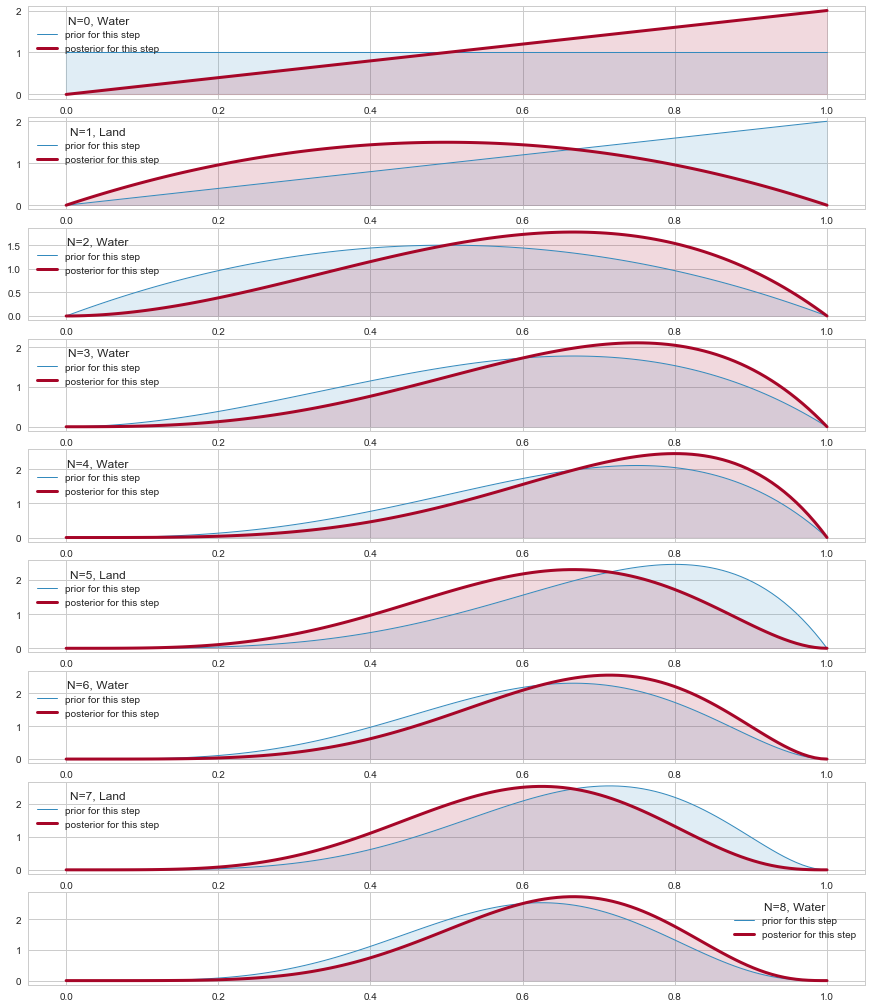

In [27]:
from scipy.stats import beta, binom

plt.figure(figsize=( 15, 18))

prior_params = np.array( [1.,1.] )  # FLAT 

x = np.linspace(0.00, 1, 125)
datastring = "WLWWWLWLW"
data=[]
for c in datastring:
    data.append(1*(c=='W'))
data=np.array(data)
print(data)
choices=['Land','Water']

# enumerating over data
for i,v in enumerate(data):
    plt.subplot(9,1,i+1)
    prior_pdf = beta.pdf( x, *prior_params)
    if v==1:
        water = [1,0]
    else:
        water = [0,1]
    posterior_params = prior_params + np.array( water )    # posteriors beta parameters
    posterior_pdf = beta.pdf( x, *posterior_params)  # the posterior 
    prior_params = posterior_params
    plt.plot( x,prior_pdf, label = r"prior for this step", lw =1, color ="#348ABD" )
    plt.plot( x, posterior_pdf, label = "posterior for this step", lw= 3, color ="#A60628" )
    plt.fill_between( x, 0, prior_pdf, color ="#348ABD", alpha = 0.15) 
    plt.fill_between( x, 0, posterior_pdf, color ="#A60628", alpha = 0.15) 
    
    plt.legend(title = "N=%d, %s"%(i, choices[v]));
    #plt.ylim( 0, 10)#

## Interrogating the posterior

Since we can sample from the posterior now after 9 observations, lets do so!

C:\Users\Jackie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


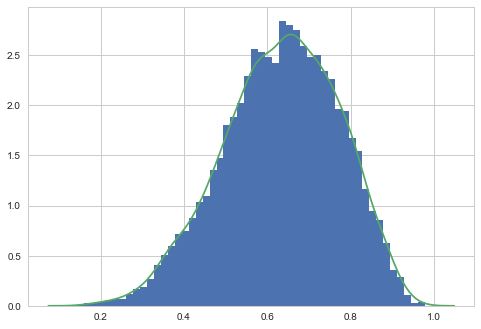

In [28]:
samples = beta.rvs(*posterior_params, size=10000)
plt.hist(samples, bins=50, normed=True);
sns.kdeplot(samples);

### Sampling to summarize

Now we can calculate all sorts of stuff.

The probability that the amount of water is less than 50%

Why are we sampling? So we can summarize the posterior with point estimates, credible intervals, etc. Frequentists could talk about the distributions in terms of bootstrapping, but not common, generally just talk about estimates.

In [29]:
np.mean(samples < 0.5)

0.17249999999999999

The probability by which we get 80% of the samples.

In [30]:
np.percentile(samples, 80)

0.75830934434363362

You might try and find a **credible interval**. This, unlike the weird definition of confidence intervals, is exactly what you think it is, the amount of probability mass between certain percentages, like the middle 95%. Confidence interval: 95% of confidence intervals contain the true value.

In [31]:
np.percentile(samples, [2.5, 97.5])

array([ 0.34691167,  0.87742223])

You can make various point estimates: mean, median

In [32]:
np.mean(samples), np.median(samples), np.percentile(samples, 50) #last 2 are same

(0.63343368627608265, 0.64047167434236474, 0.64047167434236474)

A particularly important and useful point estimate that we just saw is the **MAP**, or "maximum a-posteriori" estimate, the value of the parameter at which the pdf (num-samples) reach a maximum. It can be obtained from the samples as well.

In [33]:
sampleshisto = np.histogram(samples, bins=50)

In [34]:
maxcountindex = np.argmax(sampleshisto[0])
mapvalue = sampleshisto[1][maxcountindex]
print(maxcountindex, mapvalue)

29 0.628163283375


The mean of the posterior samples corresponds to minimizing the squared loss. Short proof, around ~55:00 in lab video. Sample median minimizes absolute error.

Mean 0.633433686276


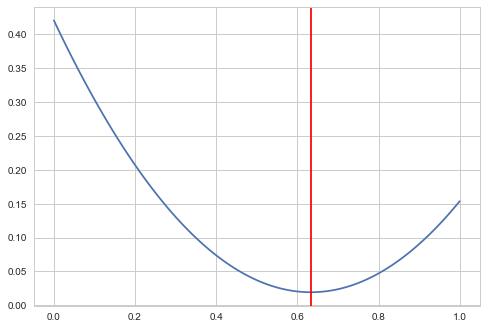

In [35]:
mse = [np.mean((xi-samples)**2) for xi in x]
plt.plot(x, mse);
plt.axvline(np.mean(samples), 0, 1, color="r")
print("Mean",np.mean(samples));

## Sampling to simulate prediction: the posterior predictive

Why would you want to simulate prediction?

1. Model Checking
2. Software Validation
3. Research Design
4. Forecasting

Its easy to sample from any one probability to get the sampling distribution at a particular $\theta$

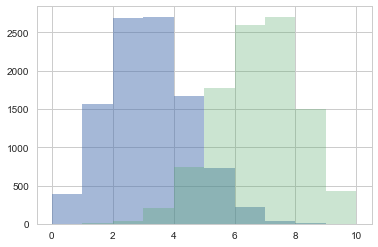

In [116]:
point3samps = np.random.binomial( len(data), 0.3, size=10000);
point7samps = np.random.binomial( len(data), 0.7, size=10000);
plt.hist(point3samps, lw=3, alpha=0.5, histtype="stepfilled", bins=np.arange(11));
plt.hist(point7samps, lw=3, alpha=0.3,histtype="stepfilled", bins=np.arange(11));

The posterior predictive:

$$p(y^{*} \vert D) = \int d\theta p(y^{*} \vert \theta) p(\theta \vert D)$$

seems to be a complex integral.  But if you parse it, its not so complex. This diagram from McElreath helps:

![](images/postpred.png)

Top: posterior distribution, w/10 unique parameter values highlighted by vertical lines 

Middle: implied distribution of observations for each parameter 

Bottom: combine sampling distributions for all values of p by using posterior probabilities to compute weighted avg frequency of each possible observation 

More honest than just using single parameter value (like most probable value at peak of posterior distribution) because incorporates ALL of uncertainty embodied in posterior distribution for parameter p.

### Plug-in Approximation

Also, often, people will use the **plug-in approximation** by putting the posterior mean or MAP value 

$$p(\theta \vert D) = \delta(\theta - \theta_{MAP})$$

and then simply  drawing the posterior predictive  from :

$$p(y^{*} \vert D) = p(y^{*} \vert \theta_{MAP})$$

(the same thing could be done for $\theta_{mean}$).

If have lots of data, MAP will match MLE.

??????

In [36]:
pluginpreds = np.random.binomial( len(data), mapvalue, size = len(samples))

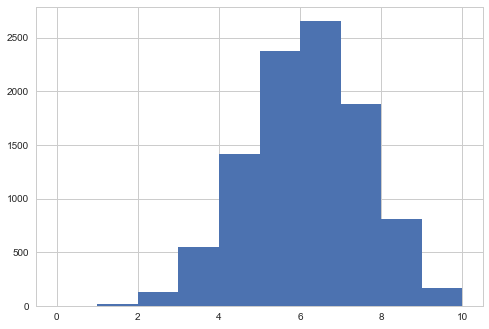

In [37]:
plt.hist(pluginpreds, bins=np.arange(11));

This approximation is just sampling from the likelihood(sampling distribution), at a posterior-obtained value of $\theta$.  It might be useful if the posterior is an expensive MCMC and the MAP is easier to find by optimization, and can be used in conjunction with quadratic (gaussian) approximations to the posterior, as we will see in variational inference. But for now we have all the samples, and it would be inane not to use them...

### The posterior predictive from sampling

But really from the perspective of sampling, all we have to do is to first draw the thetas from the posterior, then draw y's from the likelihood, and histogram the likelihood. This is the same logic as marginal posteriors, with the addition of the fact that we must draw  y from the likelihood once we drew $\theta$. You might think that we have to draw multiple $y$s at a theta, but this is already taken care of for us because of the nature of sampling. We already have multiple $\theta$s in a bin.

Sampling allows you to just use histograms to marginalize the join distributions.

In [38]:
postpred = np.random.binomial( len(data), samples);

In [39]:
postpred

array([2, 8, 4, ..., 6, 7, 6])

In [40]:
samples.shape, postpred.shape

((10000,), (10000,))

For each theta, draw a y.

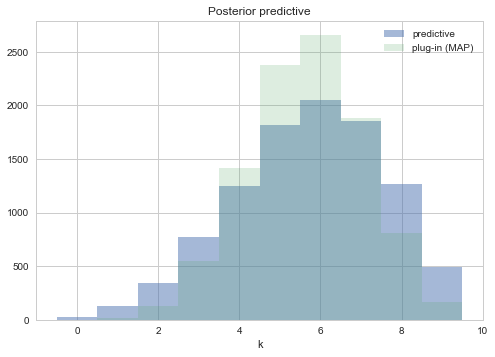

In [41]:
plt.hist(postpred, bins=np.arange(11), alpha=0.5, align="left", label="predictive")
plt.hist(pluginpreds, bins=np.arange(11), alpha=0.2, align="left", label="plug-in (MAP)")
plt.title('Posterior predictive')
plt.xlabel('k')
plt.legend()

### Replicative predictives

There is a different kind of predictive sampling that us useful (and what you might have thought was predictive sampling). This is replicative sampling. It can be used with both priors and posteriors; the former for model callibration and the latter for model checking. We shall see both of these soon.

The idea here is to generate an entire dataset from one of the parameter samples in the posterior. So you are not generating 10000 ys for 10000 thetas, but rather 10000 y's per theta. (you can play the same game with the prior). This kind of inverts the diagram we saw earlier to produce the posterior predictive.

Our usual sample vs replication 2D setup can come useful here. Consider generating 1000 y's per replication for each theta.

In [42]:
postpred.shape

(10000,)

In [43]:
reppostpred =np.empty((1000, 10000))
for i in range(1000):
    reppostpred[i,:] = np.random.binomial( len(data), samples);
reppostpred.shape

(1000, 10000)

In [44]:
per_theta_avgs = np.mean(reppostpred, axis=0)
per_theta_avgs.shape

(10000,)

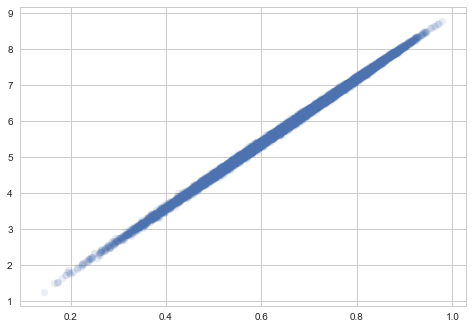

In [45]:
plt.scatter(samples, per_theta_avgs, alpha=0.1);

In particular, you will find that the number of switches is not consistent with what you see in our data. This might lead you to question our model...always a good thing..but note that we have very little data as yet to go on

In [46]:
data

array([1, 0, 1, 1, 1, 0, 1, 0, 1])

In [47]:
data[:-1] != data[1:]

array([ True,  True, False, False,  True,  True,  True,  True], dtype=bool)

In [48]:
np.sum(data[:-1] != data[1:])

6

## Exercise

You can interrogate the posterior-predictive, or **simulated** samples in other ways, asking about the longest run of water tosses, or the number of times the water/land switched. This is left as an exercise. 